        Fiscal Year                 Quarter Ending  County_Number  \
count  41708.000000                          41708   41708.000000   
mean    2017.731826  2017-11-17 07:42:55.275726336      50.612065   
min     2012.000000            2011-09-30 00:00:00       0.000000   
25%     2015.000000            2014-09-30 00:00:00      25.000000   
50%     2018.000000            2017-12-31 00:00:00      50.000000   
75%     2021.000000            2020-12-31 00:00:00      77.000000   
max     2024.000000            2023-12-31 00:00:00      99.000000   
std        3.645090                            NaN      28.380570   

       Number of Returns  Taxable Sales  Computed Tax  Percent of Tax  \
count       41708.000000   4.170800e+04  4.170800e+04    41708.000000   
mean          114.754675   1.208873e+07  7.225693e+05        0.119507   
min             1.000000   0.000000e+00  0.000000e+00        0.000000   
25%            19.000000   4.061832e+05  2.435600e+04        0.000000   
50%          

C:\Users\vidya\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


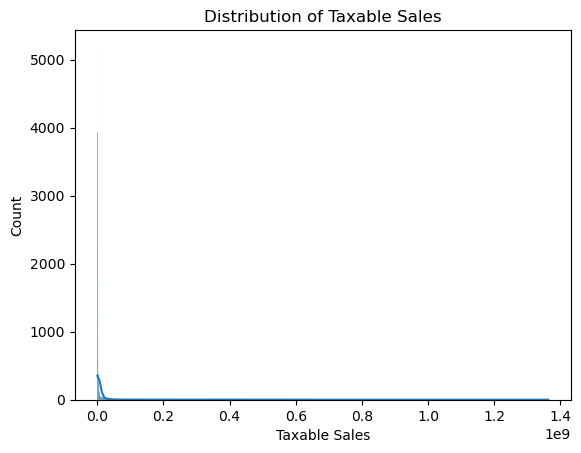

  County         City  Taxable Sales
0  Adair        Adair   1.429378e+08
1  Adair  Bridgewater   1.391065e+07
2  Adair        Casey   1.312571e+06
3  Adair   Fontanelle   4.757781e+07
4  Adair   Greenfield   3.696812e+08
       County          City  Taxable Sales  Rank
742      Polk    Des Moines   4.971602e+10   1.0
563      Linn  Cedar Rapids   4.064138e+10   2.0
804     Scott     Davenport   2.729400e+10   3.0
975  Woodbury    Sioux City   2.036445e+10   4.0
298   Dubuque       Dubuque   1.471034e+10   5.0
Linear Regression MAE: 17733952.784922604, MSE: 3355538468229638.5, RMSE: 57927009.833320744
                               SARIMAX Results                                
Dep. Variable:          Taxable Sales   No. Observations:                41708
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -807028.402
Date:                Sun, 14 Jul 2024   AIC                        1614068.805
Time:                        17:35:41   BIC                        1614120.

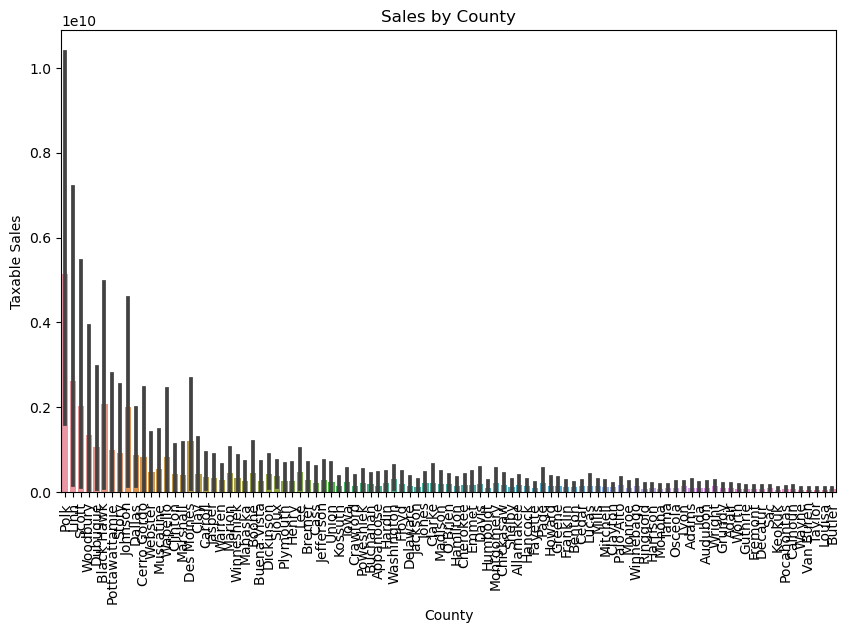

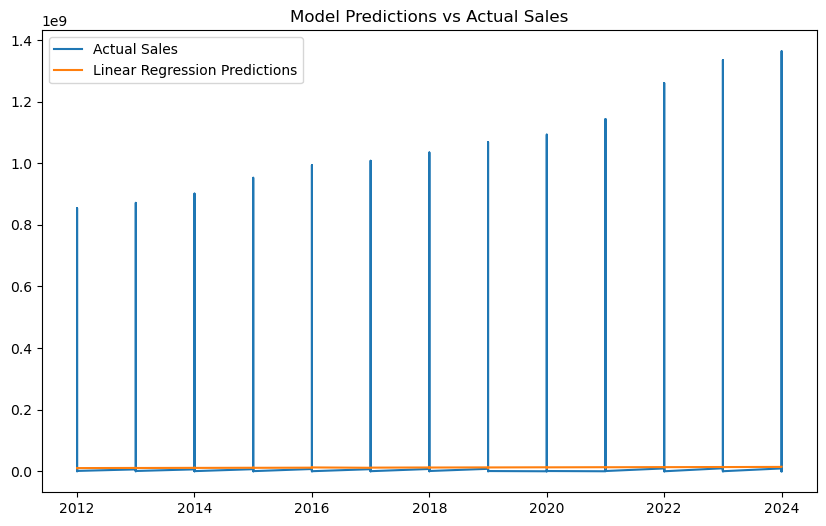

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load dataset
data = pd.read_csv('..\\data\\raw\\Quarterly_Retail_Sales_Tax_Data_by_County_and_City.csv')

# Data Preprocessing
# Handle missing values
data.ffill(inplace=True)

# Convert infinite values to NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convert 'Quarter Ending' to datetime
data['Quarter Ending'] = pd.to_datetime(data['Quarter Ending'], errors='coerce')

# Drop rows with invalid dates
data.dropna(subset=['Quarter Ending'], inplace=True)

# Extract year and quarter from 'Quarter Ending'
data['Year'] = data['Quarter Ending'].dt.year
data['Quarter'] = data['Quarter Ending'].dt.quarter

# EDA
# Summary statistics
print(data.describe())

# Visualize data distributions
sns.histplot(data['Taxable Sales'].dropna(), kde=True)  # Drop NaN values for the plot
plt.title('Distribution of Taxable Sales')
plt.show()

# Aggregate sales and tax data by county and city
county_city_sales = data.groupby(['County', 'City'])['Taxable Sales'].sum().reset_index()
print(county_city_sales.head())

# Comparative Analysis
# Rank counties and cities based on their sales performance
county_city_sales['Rank'] = county_city_sales['Taxable Sales'].rank(ascending=False)
print(county_city_sales.sort_values('Rank').head())

# Feature Engineering
# Create new features
data['Sales Per Capita'] = data['Taxable Sales'] / data['Number of Returns']
data['Sales Growth Rate'] = data['Taxable Sales'].pct_change()

# Model Building
# Linear Regression
X = data[['Year', 'Quarter']]
y = data['Taxable Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Model Evaluation
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print(f'Linear Regression MAE: {mae_lr}, MSE: {mse_lr}, RMSE: {rmse_lr}')

# ARIMA
arima_model = ARIMA(data['Taxable Sales'], order=(5, 1, 0))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=len(y_test))
print(arima_result.summary())

# SARIMA
sarima_model = SARIMAX(data['Taxable Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_pred = sarima_result.forecast(steps=len(y_test))
print(sarima_result.summary())

# Visualization
# Sales and tax contributions by county and city
plt.figure(figsize=(10, 6))
sns.barplot(x='County', y='Taxable Sales', data=county_city_sales.sort_values('Taxable Sales', ascending=False))
plt.title('Sales by County')
plt.xticks(rotation=90)
plt.show()

# Model predictions vs actual sales
plt.figure(figsize=(10, 6))
plt.plot(data['Fiscal Year'], data['Taxable Sales'], label='Actual Sales')
plt.plot(data['Fiscal Year'], lr_model.predict(X), label='Linear Regression Predictions')
plt.legend()
plt.title('Model Predictions vs Actual Sales')
plt.show()


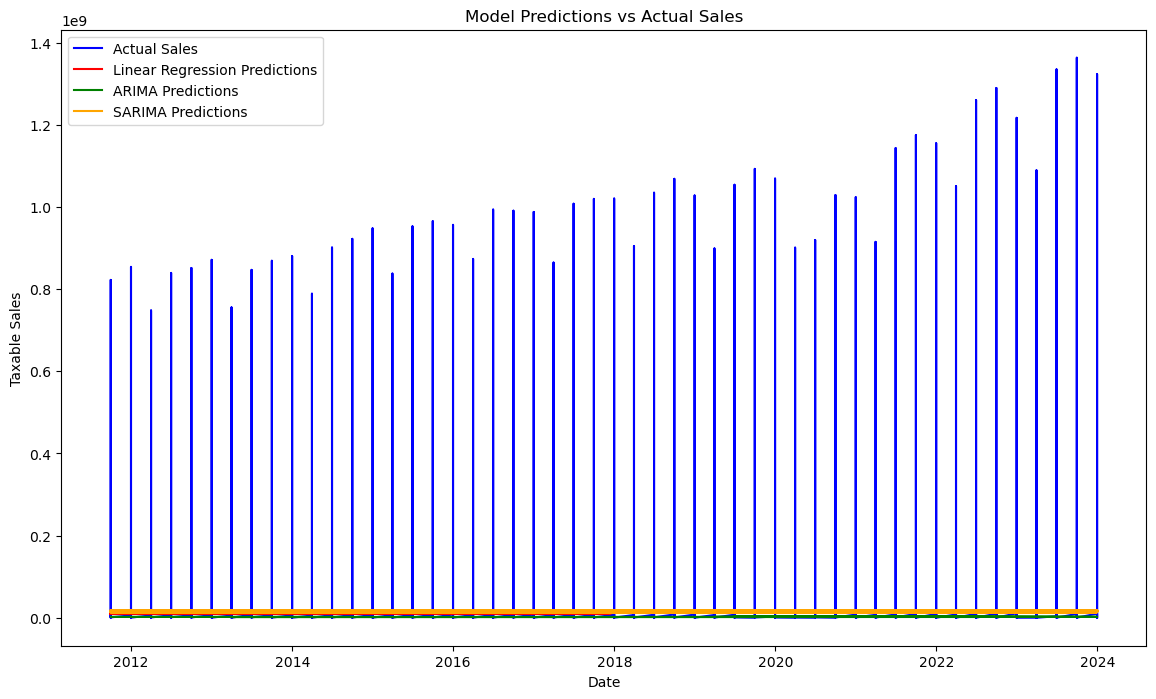

In [9]:
# Visualization
plt.figure(figsize=(14, 8))

# Plot actual sales
plt.plot(data['Quarter Ending'], data['Taxable Sales'], label='Actual Sales', color='blue')

# Plot Linear Regression predictions
test_dates = data.iloc[X_test.index]['Quarter Ending']
plt.plot(test_dates, y_pred_lr, label='Linear Regression Predictions', color='red')

# Plot ARIMA predictions
plt.plot(test_dates, arima_pred, label='ARIMA Predictions', color='green')

# Plot SARIMA predictions
plt.plot(test_dates, sarima_pred, label='SARIMA Predictions', color='orange')

plt.legend()
plt.title('Model Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Taxable Sales')
plt.show()